<a href="https://colab.research.google.com/github/elangbijak4/Humanoid-Robot/blob/main/Demo2%20-%201%20Agen%20vs%201%20Join%20Sendi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing ipympl...
Using device: cpu
Start training (may take a few minutes)...
Epoch 1/300 - loss: 0.671441
Epoch 50/300 - loss: 0.017528
Epoch 100/300 - loss: 0.009880
Epoch 150/300 - loss: 0.007077
Epoch 200/300 - loss: 0.005809
Epoch 250/300 - loss: 0.004830
Epoch 300/300 - loss: 0.004062
Training finished.
Final error ANN: 0.0177 after 116 steps
Final error Jacobian: 0.0195 after 135 steps


Fallback inline mode (less smooth). Click Play to animate; loop will advance frames.


IndexError: index 116 is out of bounds for axis 0 with size 116

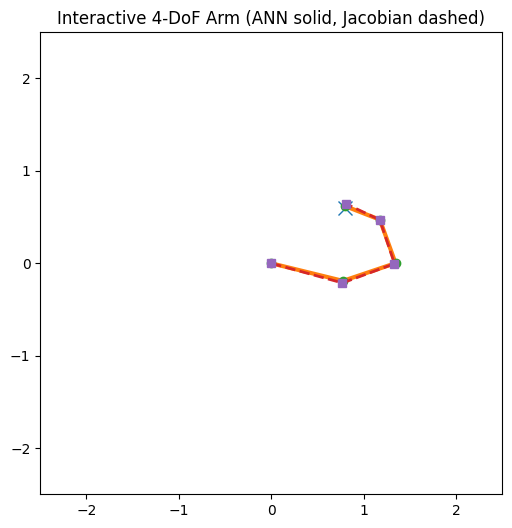

IndexError: index 116 is out of bounds for axis 0 with size 116

In [4]:
# Colab-ready: PyTorch + ipympl interactive demo for 4-DoF planar arm controlled by ANN
# Paste all into one Colab cell and run.

# -------------------------
# 0) Install dependencies if missing (ipympl, ipywidgets)
# -------------------------
import sys
import subprocess
import importlib

def ensure_pkg(pkg_name, import_name=None):
    try:
        importlib.import_module(import_name or pkg_name)
    except Exception:
        print(f"Installing {pkg_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])

# ipympl and ipywidgets needed for interactive widget backend
ensure_pkg("ipympl")
ensure_pkg("ipywidgets")
# torch: only install if not available (Colab normally has it)
try:
    import torch
except Exception:
    print("Installing torch (CPU version)...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch"])
    import torch

# -------------------------
# 1) Imports & backend
# -------------------------
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
import time
import torch
import torch.nn as nn
import torch.optim as optim

# Try to enable interactive widget backend for matplotlib
try:
    %matplotlib widget
    use_ipympl = True
except Exception:
    %matplotlib inline
    use_ipympl = False

# -------------------------
# 2) Robot kinematics (4-DoF planar)
# -------------------------
DOF = 4
LINKS = np.array([0.8, 0.6, 0.5, 0.4])  # total reach ~2.3

def forward_kinematics(q):
    # q: (..., DOF)
    qs = np.cumsum(q, axis=-1)
    x = np.cumsum(np.cos(qs) * LINKS, axis=-1)
    y = np.cumsum(np.sin(qs) * LINKS, axis=-1)
    pts = np.stack([x, y], axis=-1)  # (..., DOF, 2)
    origin = np.zeros_like(pts[..., :1, :])  # (...,1,2)
    joints = np.concatenate([origin, pts], axis=-2)  # (..., DOF+1, 2)
    ee = joints[..., -1, :]
    return ee, joints

def jacobian(q):
    J = np.zeros((2, DOF))
    angles = np.cumsum(q)
    for i in range(DOF):
        s = np.sum(np.sin(angles[i:]) * LINKS[i:])
        c = np.sum(np.cos(angles[i:]) * LINKS[i:])
        J[0, i] = -s
        J[1, i] = c
    return J

def jacobian_transpose_control(q, target, alpha=1.0):
    ee, _ = forward_kinematics(q[None, :])
    ee = ee[0]
    error = target - ee
    J = jacobian(q)
    qdot = alpha * J.T.dot(error)
    qdot = np.clip(qdot, -2.0, 2.0)
    return qdot

# -------------------------
# 3) Dataset generation
# -------------------------
def generate_dataset(n_samples=6000):
    Q = np.random.uniform(-np.pi/2, np.pi/2, size=(n_samples, DOF))
    angles = np.random.uniform(0, 2*np.pi, size=(n_samples,))
    radii = np.random.uniform(0.2, LINKS.sum()*0.95, size=(n_samples,))
    T = np.stack([radii*np.cos(angles), radii*np.sin(angles)], axis=-1)
    QDOT = np.array([jacobian_transpose_control(q, t, alpha=0.8) for q,t in zip(Q,T)])
    X = np.concatenate([Q, T], axis=-1).astype(np.float32)
    Y = QDOT.astype(np.float32)
    return X, Y

X_np, Y_np = generate_dataset(5000)

# -------------------------
# 4) PyTorch MLP model
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class MLP_torch(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

input_dim = DOF + 2
hidden_dim = 128
output_dim = DOF
model = MLP_torch(input_dim, hidden_dim, output_dim).to(device)

# -------------------------
# 5) Training
# -------------------------
def train_model(model, X_np, Y_np, epochs=300, batch_size=128, lr=5e-4):
    model.train()
    X = torch.from_numpy(X_np).to(device)
    Y = torch.from_numpy(Y_np).to(device)
    dataset = torch.utils.data.TensorDataset(X, Y)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for ep in range(1, epochs+1):
        total_loss = 0.0
        for xb, yb in loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb.size(0)
        avg_loss = total_loss / len(dataset)
        if ep % 50 == 0 or ep==1 or ep==epochs:
            print(f"Epoch {ep}/{epochs} - loss: {avg_loss:.6f}")
    return model

print("Start training (may take a few minutes)...")
model = train_model(model, X_np, Y_np, epochs=300, batch_size=256, lr=5e-4)
print("Training finished.")

# -------------------------
# 6) Episode simulation (compare ANN vs Jacobian)
# -------------------------
def run_episode(initial_q, target, controller_fn, dt=0.05, steps=400):
    qs = []
    errs = []
    q = initial_q.copy()
    for _ in range(steps):
        inp = np.concatenate([q, target])[None, :].astype(np.float32)
        qdot = controller_fn(inp)[0]
        q = q + qdot * dt
        qs.append(q.copy())
        ee, _ = forward_kinematics(q[None, :])
        errs.append(np.linalg.norm(target - ee[0]))
        if errs[-1] < 0.02:
            break
    return np.array(qs), np.array(errs)

# wrappers
def ann_controller_np(x_np):
    model.eval()
    with torch.no_grad():
        t = torch.from_numpy(x_np.astype(np.float32)).to(device)
        out = model(t).cpu().numpy()
    return out

def jac_controller_batch(x_np):
    outs = []
    for row in x_np:
        q = row[:DOF]
        t = row[DOF:]
        outs.append(jacobian_transpose_control(q, t, alpha=0.8))
    return np.array(outs)

# Pick initial and target
initial_q = np.random.uniform(-0.5, 0.5, size=(DOF,))
target = np.array([0.8, 0.6], dtype=np.float32)

qs_ann, errs_ann = run_episode(initial_q, target, ann_controller_np, dt=0.05, steps=400)
qs_jac, errs_jac = run_episode(initial_q, target, jac_controller_batch, dt=0.05, steps=400)

print(f"Final error ANN: {errs_ann[-1]:.4f} after {len(errs_ann)} steps")
print(f"Final error Jacobian: {errs_jac[-1]:.4f} after {len(errs_jac)} steps")

# -------------------------
# 7) Precompute joint positions for animation
# -------------------------
def compute_joints_sequence(qs):
    seq = []
    for q in qs:
        _, joints = forward_kinematics(q[None,:])
        seq.append(joints[0])
    return np.array(seq)

joints_ann_seq = compute_joints_sequence(qs_ann)
joints_jac_seq = compute_joints_sequence(qs_jac)
max_frames = max(len(joints_ann_seq), len(joints_jac_seq))

# -------------------------
# 8) Interactive UI: Play + Slider + Plot (ipympl)
# -------------------------
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal', 'box')
ax.set_xlim(-sum(LINKS)-0.2, sum(LINKS)+0.2)
ax.set_ylim(-sum(LINKS)-0.2, sum(LINKS)+0.2)
ax.set_title('Interactive 4-DoF Arm (ANN solid, Jacobian dashed)')
target_plot, = ax.plot([target[0]], [target[1]], marker='x', markersize=10)

# artists
line_ann, = ax.plot([], [], linewidth=3)
pts_ann, = ax.plot([], [], marker='o', linestyle='')
line_jac, = ax.plot([], [], linestyle='--', linewidth=2)
pts_jac, = ax.plot([], [], marker='s', linestyle='')

def draw_frame(frame_idx):
    idx = min(frame_idx, max_frames-1)
    ja = joints_ann_seq[idx]
    jj = joints_jac_seq[idx]
    line_ann.set_data(ja[:,0], ja[:,1])
    pts_ann.set_data(ja[:,0], ja[:,1])
    line_jac.set_data(jj[:,0], jj[:,1])
    pts_jac.set_data(jj[:,0], jj[:,1])
    if not use_ipympl:
        fig.canvas.draw_idle()

# Widgets
play = widgets.Play(value=0, min=0, max=max_frames-1, step=1, interval=40, description="Play")
slider = widgets.IntSlider(value=0, min=0, max=max_frames-1, step=1, description='Frame')
widgets.jslink((play, 'value'), (slider, 'value'))

btn_start = widgets.Button(description='<< Start')
btn_end = widgets.Button(description='End >>')
btn_pause = widgets.ToggleButton(value=False, description='Pause')

def on_start(b): play.value = 0
def on_end(b): play.value = max_frames-1
btn_start.on_click(on_start)
btn_end.on_click(on_end)

def on_slider_change(change):
    draw_frame(change['new'])
slider.observe(on_slider_change, names='value')

controls = widgets.HBox([play, slider, btn_start, btn_pause, btn_end])
display(controls)

# If ipympl available we rely on slider.observe for interactive redraw.
if use_ipympl:
    print("Using ipympl interactive backend. Click Play to animate.")
else:
    print("Fallback inline mode (less smooth). Click Play to animate; loop will advance frames.")
    last = play.value
    try:
        while True:
            cur = play.value
            if cur != last:
                draw_frame(cur)
                last = cur
            # advance if not paused
            if not btn_pause.value and play.value < play.max:
                play.value = min(play.max, play.value + 1)
                last = play.value
                draw_frame(play.value)
            if play.value == play.max:
                time.sleep(0.05)
                break
            time.sleep(0.04)
    except KeyboardInterrupt:
        pass

# -------------------------
# 9) Also display error plot below for reference
# -------------------------
import matplotlib.gridspec as gridspec
fig2 = plt.figure(figsize=(6,3.5))
ax2 = fig2.add_subplot(1,1,1)
ax2.plot(errs_ann, label='ANN')
ax2.plot(errs_jac, label='Jacobian-transpose')
ax2.set_xlabel('Timestep')
ax2.set_ylabel('End-effector error (m)')
ax2.set_title('Error over time')
ax2.legend()
plt.show()

print("Widget ready — gunakan Play / Slider untuk mengendalikan animasi.")
